In [2]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA

import sys
sys.path.append("../../ibl_analyses/")
sys.path.append("../../siegel_analyses/scripts/")
import netrep_helpers as nh
import utils
from sklearn.manifold import MDS
from scikits.bootstrap import bootstrap as bt
from scipy.stats import ttest_ind
import tqdm
import seaborn as sns
from netrep.metrics import LinearMetric
from netrep.utils import whiten, angular_distance
from mvlearn.embed import GCCA
import imp
imp.reload(utils)


/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_3950/3655872482.py:20: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'utils' from '/Users/jbarbosa/Dropbox/Neuro/papers/shapemetrics_journalpaper/Peyrach/notebooks/../../ibl_analyses/utils.py'>

In [3]:
from netrep.multiset import frechet_mean

In [4]:
sessions_1 = glob.glob('../Dataset_1/*')
sessions_2 = glob.glob('../Dataset_2/*')
sessions_3 = glob.glob('../Dataset_3/*')

sessions = sessions_1 + sessions_2 #+ sessions_3

In [75]:

HD_fold = []
n_folds = 40
n_pcs = 10
pca = PCA(n_components=n_pcs)


total_neurons = []
all_celltypes = []
fold1 = []
fold2 = []
for session in tqdm.tqdm(sessions):

    # tuning curves computed with two halves of the behavioral data (same neurons)
    hd_data = loadmat(session + '/Analysis/HdTuning_xval_moveEp.mat')
    celltypes = loadmat(session + '/CellTypes.mat')
    all_celltypes.append(celltypes)
    idx = celltypes["fs"].reshape(-1)==1
    data_1 = hd_data["hAll1"][:,idx,12]# last index is smoothing window. 12 seems great
    data_2 = hd_data["hAll2"][:,~idx,12]

    fold1.append(data_1.T)
    fold2.append(data_2.T)
    continue
    N = len(data_1[0])
    if N < 10:
        continue
    idx = np.arange(N)
    many_folds = []
    for fold in range(n_folds):

        np.random.shuffle(idx)
        pcs_1 = pca.fit_transform(data_1)   
        pcs_2 = pca.fit_transform(data_2)
        
        many_folds.append([pcs_1,pcs_2])

    HD_fold.append(many_folds)

    # cv in time


sh = np.shape(HD_fold)
HD_many_folds = np.array(HD_fold).transpose(1,0,2,3,4).reshape(sh[1],-1,sh[3],sh[4])
HD_fold  = HD_many_folds[0]


100%|██████████| 31/31 [00:02<00:00, 13.10it/s]


ValueError: axes don't match array

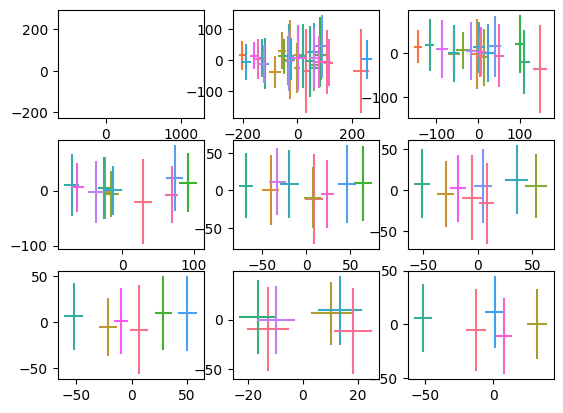

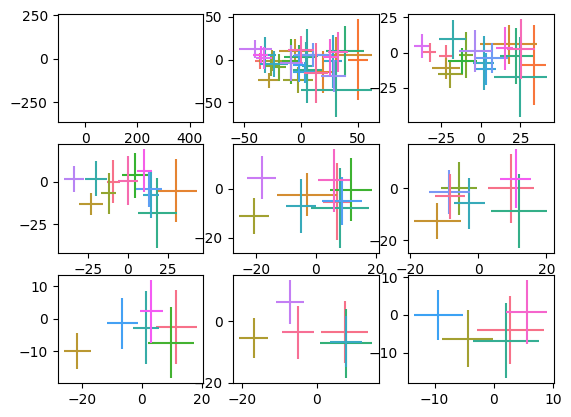

In [81]:
all_in_1 = np.concatenate(fold1)
all_in_2 = np.concatenate(fold2)

pca_1 = PCA(n_components=10).fit_transform(all_in_1)
pca_2 = PCA(n_components=10).fit_transform(all_in_2)




colors = sns.color_palette("husl", 360)

for wi,w in enumerate(range(1,90,10)):
    plt.subplot(3,3,wi+1)
    [plt.errorbar(np.mean(pca_1[p:p+w,0],0),np.mean(pca_1[p:p+w,1],0),np.std(pca_1[p:p+w,0],0)/np.sqrt(w),np.std(pca_1[p:p+w,1],0)/np.sqrt(w),color=colors[p]) for p in range(0,360,w)]
   # [plt.errorbar(np.mean(pca_2[p:p+w,0],0),np.mean(pca_2[p:p+w,1],0),np.std(pca_2[p:p+w,0],0)/np.sqrt(w),np.std(pca_2[p:p+w,1],0)/np.sqrt(w),color=colors[p]) for p in range(0,360,w)]

plt.figure()
for wi,w in enumerate(range(1,90,10)):
    plt.subplot(3,3,wi+1)
    [plt.errorbar(np.mean(pca_2[p:p+w,0],0),np.mean(pca_2[p:p+w,1],0),np.std(pca_2[p:p+w,0],0)/np.sqrt(w),np.std(pca_2[p:p+w,1],0)/np.sqrt(w),color=colors[p]) for p in range(0,360,w)]

In [59]:
S=len(sessions)
print(S)

S_tot = len(HD_fold)
print(S_tot)

31
0


In [60]:

def plot_fold(Xi, Xj,ax):
    
    ax.plot(Xi[:,0], Xi[:,1], Xi[:,2],color="darkblue",label="fold 1")
    ax.plot(Xj[:,0], Xj[:,1], Xj[:,2],color="darkorange",label="fold 2")

    ax.plot(Xi[:,0], Xi[:,1], ax.get_zlim()[0],alpha=0.1,color="darkblue")
    ax.plot(Xj[:,0], Xj[:,1], ax.get_zlim()[0],alpha=0.1,color="darkorange")


    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

fig = plt.figure(figsize=(9,S*2))

HD_fold  = HD_many_folds[0]

for s,si in enumerate(range(0,S_tot,S_tot//S)):

    Xi,Xj =  HD_fold[si],HD_fold[si+1]

    metric = LinearMetric(alpha=0,center_columns=True,score_method='euclidean')
    metric.fit(Xi,Xj)
    Xi_0,Xj_0=metric.transform(Xi,Xj)


    metric = LinearMetric(alpha=1,center_columns=True,score_method='euclidean')
    metric.fit(Xi,Xj)
    Xi_1,Xj_1=metric.transform(Xi,Xj)


    # neural folds
    ax = fig.add_subplot(S,6,1 + (s*6), projection='3d')
    plot_fold(Xi,Xj,ax)
    if s == 0:
        ax.set_title("raw (neuron folds)\n#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi,Xj))))
    else:
        ax.set_title("#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi,Xj))))

    ax = fig.add_subplot(S,6,2 + (s*6), projection='3d')
    plot_fold(Xi_1,Xj_1,ax)
    
    if s == 0:
        ax.set_title(r"$\alpha=1$""\n#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi_1,Xj_1))))
    else:
        ax.set_title("\n#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi_1,Xj_1))))


    ax = fig.add_subplot(S,6,3 + (s*6), projection='3d')
    plot_fold(Xi_0,Xj_0,ax)
    
    if s == 0:
        ax.set_title(r"$\alpha=0$""\n#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi_0,Xj_0))))
    else:
        ax.set_title("#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi_0,Xj_0))))



    ax.legend(loc='upper right',bbox_to_anchor=(2, 1))


NameError: name 'HD_many_folds' is not defined

<Figure size 900x6200 with 0 Axes>

In [ ]:
imp.reload(utils)

#neural folds
many_dist_neural_alpha_0 = []
many_dist_neural_alpha_1 = []
for fold in tqdm.tqdm(HD_many_folds):

    dist_neural_alpha_0 = np.zeros((S_tot,S_tot))*np.nan
    dist_neural_alpha_1 = np.zeros((S_tot,S_tot))*np.nan
    for i in range(len(fold)):
        for j in range(i,len(fold)):
 
            dist_neural_alpha_0[i,j]=dist_neural_alpha_0[j,i]=utils.dsd([[fold[i],fold[j]]],alpha=0)
            dist_neural_alpha_1[i,j]=dist_neural_alpha_1[j,i]=utils.dsd([[fold[i],fold[j]]],alpha=1)

    many_dist_neural_alpha_0.append(dist_neural_alpha_0)
    many_dist_neural_alpha_1.append(dist_neural_alpha_1)


# just to ensure symmetry. Somehow alpha=0 is slightly not symmetric
dist_neural_alpha_0 = (dist_neural_alpha_0+dist_neural_alpha_0.T)/2
dist_neural_alpha_1 = (dist_neural_alpha_1+dist_neural_alpha_1.T)/2


  0%|          | 0/40 [00:00<?, ?it/s]/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_2995/102523030.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_neural_alpha_0[i,j]=dist_neural_alpha_0[j,i]=utils.dsd([[fold[i],fold[j]]],alpha=0)
/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_2995/102523030.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_neural_alpha_1[i,j]=dist_neural_alpha_1[j,i]=utils.dsd([[fold[i],fold[j]]],alpha=1)
100%|██████████| 40/40 [05:08<00:00,  7.71s/it]


IndexError: index 44 is out of bounds for axis 0 with size 44

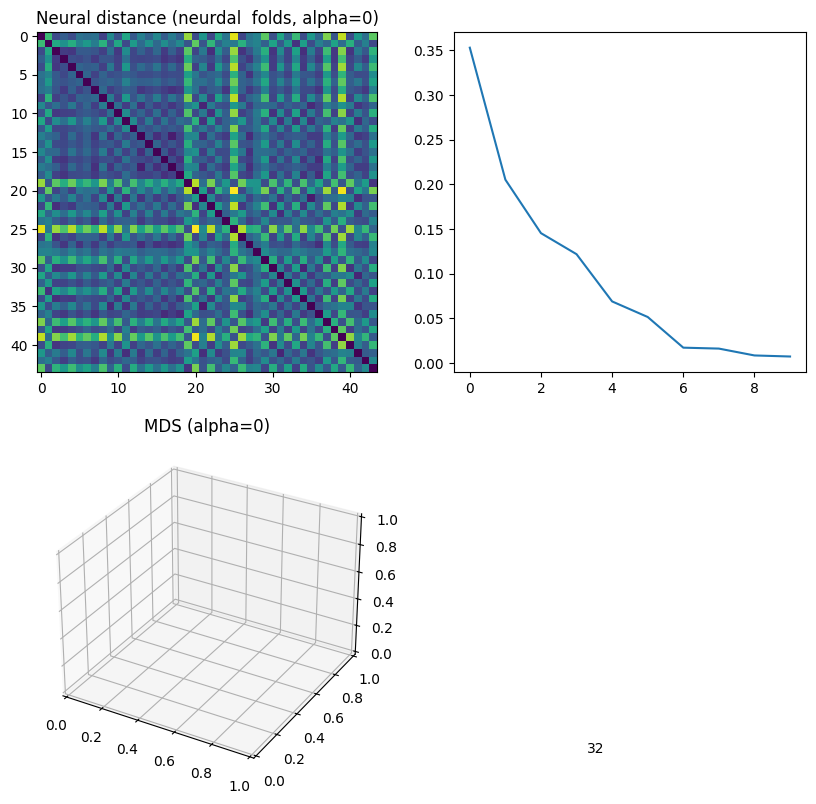

In [ ]:

fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(321)

dist_mds_alpha_0 = MDS(n_components=3,dissimilarity="precomputed",normalized_stress=False).fit_transform(dist_neural_alpha_0) 
pca_dist_alpha_0 = PCA(n_components=10).fit_transform(dist_neural_alpha_0)

dist_mds_alpha_1 = MDS(n_components=3,dissimilarity="precomputed",normalized_stress=False).fit_transform(dist_neural_alpha_1) 
pca_dist_alpha_1 = PCA(n_components=10).fit_transform(dist_neural_alpha_1)

ax.title.set_text("Neural distance (neurdal  folds, alpha=0)")
ax.imshow(dist_neural_alpha_0)

ax = fig.add_subplot(322)
ax.plot(pca.explained_variance_ratio_)

ax = fig.add_subplot(323, projection='3d')
ax.set_title("MDS (alpha=0)")
# add numbers to points
for i in range(S*2):
    ax.text(dist_mds_alpha_0[i,0],dist_mds_alpha_0[i,1],dist_mds_alpha_0[i,2],str(i))
ax.plot(dist_mds_alpha_0[:,0],dist_mds_alpha_0[:,1],dist_mds_alpha_0[:,2],"o",ms=8)
ax.set_xticks(ax.get_xticks(),[])
ax.set_yticks(ax.get_yticks(),[])
ax.set_zticks(ax.get_zticks(),[])


ax = fig.add_subplot(324, projection='3d')
ax.set_title("PCA (alpha=0)")
for i in range(S*2):
    ax.text(pca_dist_alpha_0[i,0],pca_dist_alpha_0[i,1],pca_dist_alpha_0[i,2],str(i))
ax.plot(pca_dist_alpha_0[:,0],pca_dist_alpha_0[:,1],pca_dist_alpha_0[:,2],"o",ms=8)
ax.set_xticks(ax.get_xticks(),[])
ax.set_yticks(ax.get_yticks(),[])
ax.set_zticks(ax.get_zticks(),[])
fig.tight_layout()

ax = fig.add_subplot(325, projection='3d')
ax.set_title("MDS (alpha=1)")
# add numbers to points
for i in range(S*2):
    ax.text(dist_mds_alpha_1[i,0],dist_mds_alpha_1[i,1],dist_mds_alpha_1[i,2],str(i))
ax.plot(dist_mds_alpha_1[:,0],dist_mds_alpha_1[:,1],dist_mds_alpha_1[:,2],"o",ms=8)
ax.set_xticks(ax.get_xticks(),[])
ax.set_yticks(ax.get_yticks(),[])
ax.set_zticks(ax.get_zticks(),[])


ax = fig.add_subplot(326, projection='3d')
ax.set_title("PCA (alpha=1)")
for i in range(S*2):
    ax.text(pca_dist_alpha_1[i,0],pca_dist_alpha_1[i,1],pca_dist_alpha_1[i,2],str(i))
ax.plot(pca_dist_alpha_1[:,0],pca_dist_alpha_1[:,1],pca_dist_alpha_1[:,2],"o",ms=8)
ax.set_xticks(ax.get_xticks(),[])
ax.set_yticks(ax.get_yticks(),[])
ax.set_zticks(ax.get_zticks(),[])
fig.tight_layout()

[255.38134014 264.05223669]
[235.17142566 280.48547435]


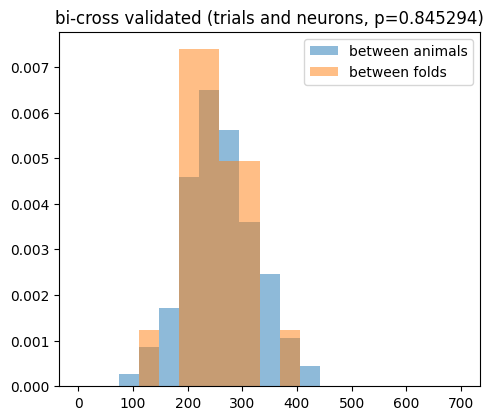

In [ ]:

# cv neural
plt.figure(figsize=(5,8))

plt.subplot(211)
all_tests_0 = []
all_tests_1 = []
for di,dist in enumerate(many_dist_neural_alpha_0):

    other_dists = dist[np.triu_indices(S_tot,2)].reshape(-1)
    between_folds = dist[range(0,S_tot,2),range(1,S_tot,2)]
    t,p = ttest_ind(other_dists,between_folds)
    all_tests_0.append([t,p])

    dist = many_dist_neural_alpha_1[di]
    other_dists = dist[np.triu_indices(S_tot,2)].reshape(-1)
    between_folds = dist[range(0,S_tot,2),range(1,S_tot,2)]
    t,p = ttest_ind(other_dists,between_folds)
    all_tests_1.append([t,p])

plt.hist(other_dists,density=True,bins=np.linspace(0,700,20),alpha=0.5,label="between animals")
plt.hist(between_folds,density=True,bins=np.linspace(0,700,20),alpha=0.5,label="between folds")
plt.legend()

print(bt.ci(other_dists))
print(bt.ci(between_folds))

plt.title("bi-cross validated (trials and neurons, p=%f)" % p)
plt.tight_layout()

TtestResult(statistic=np.float64(-0.20091911933691994), pvalue=np.float64(0.841806007796967), df=np.int64(39))
TtestResult(statistic=np.float64(3.2544973277358724), pvalue=np.float64(0.0023507093524073146), df=np.int64(39))


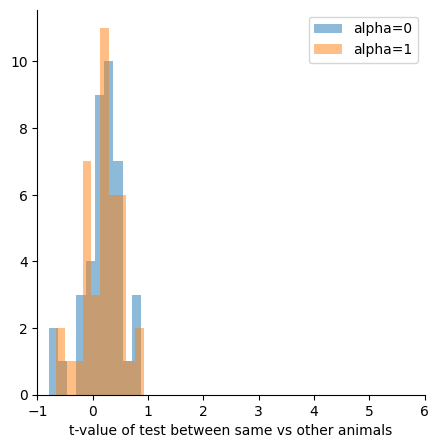

In [ ]:
plt.figure(figsize=(5,5))
from scipy.stats import ttest_1samp,ttest_rel
print(ttest_rel(np.array(all_tests_0)[:,0],(np.array(all_tests_1)[:,0])))
print(ttest_1samp(np.array(all_tests_0)[:,0],0))

plt.hist(np.array(all_tests_0)[:,0],alpha=0.5,label="alpha=0")
plt.hist(np.array(all_tests_1)[:,0],alpha=0.5,label="alpha=1")
plt.xlabel("t-value of test between same vs other animals")
plt.xlim(-1,6)
plt.legend()
sns.despine()

## clustering

PearsonRResult(statistic=0.6939957516255224, pvalue=7.395803281450359e-46)


/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/jbarbosa/anaconda3/envs/netrep/lib/python

/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-pack

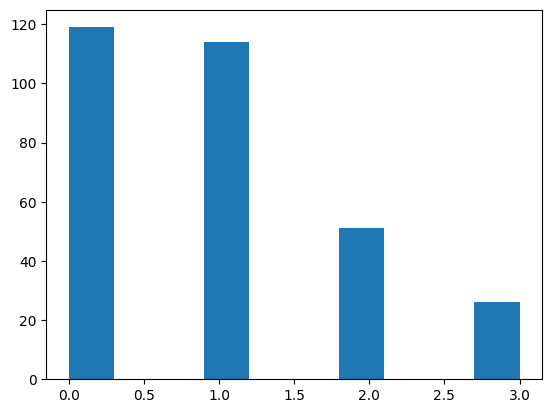

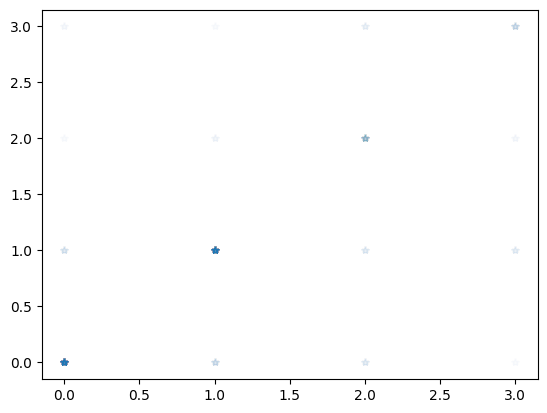

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr

all_clustering = []
for dist_neural_alpha_0 in many_dist_neural_alpha_0:
    clustering = AgglomerativeClustering(n_clusters=4,affinity="precomputed",linkage='average').fit(dist_neural_alpha_0)
    all_clustering.append(clustering.labels_)

all_clustering = np.array(all_clustering)


plt.hist(all_clustering[:,range(0,S_tot,2)].reshape(-1))
plt.figure()
print(pearsonr(all_clustering[:,range(0,S_tot,2)].reshape(-1),all_clustering[:,range(1,S_tot,2)].reshape(-1)))
plt.plot(all_clustering[:,range(0,S_tot,2)].reshape(-1),all_clustering[:,range(1,S_tot,2)].reshape(-1),'*',alpha=0.01)

skippin,  1


/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-pack

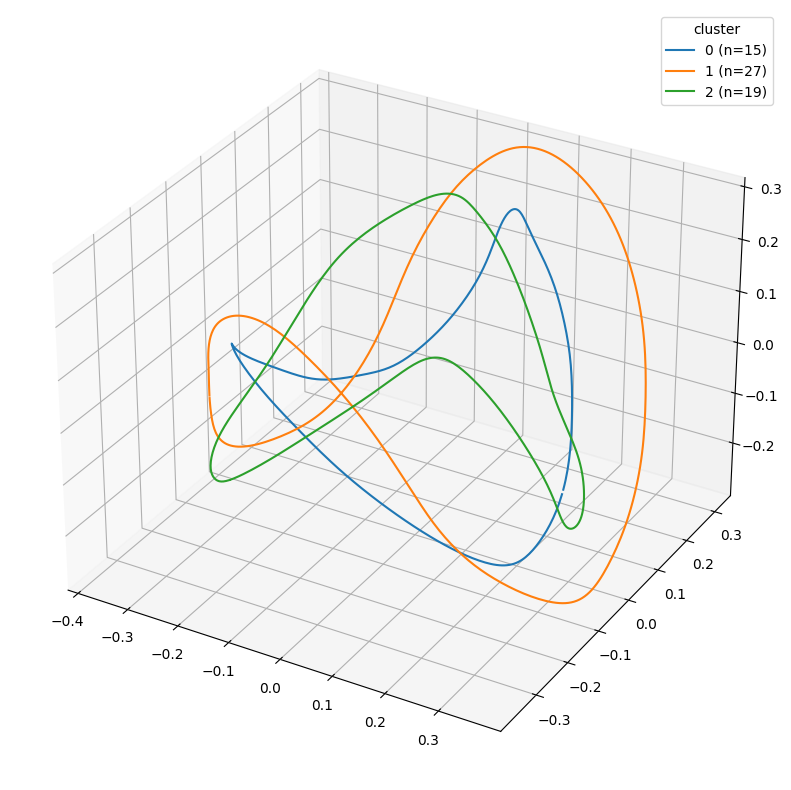

In [ ]:
gcca = GCCA(n_components=3)
# plot 3d
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for c in np.unique(clustering.labels_):
    idx = np.where(clustering.labels_==c)[0]
    if len(idx)<5:
        print('skippin, ',len(idx))  
        continue  
    gcca_aligned = np.array(gcca.fit_transform(HD_many_folds[-1][idx]))
    m_gcca = gcca_aligned.mean(0)
    ax.plot(m_gcca[:,0],m_gcca[:,1],m_gcca[:,2],label='%i (n=%i)' % (c,len(idx)))
    #[plt.plot(gcca_aligned[i,:,0],gcca_aligned[i,:,1],color='grey',alpha=0.5) for i in range(len(idx))]
    # plt.suptitle(c)
    # for ii,i in enumerate(np.where(clustering.labels_==c)[0]):
    #     plt.subplot(5,6,ii+1)
    #     [plt.plot(HD_many_folds[-1][i][p,0],HD_many_folds[-1][i][p,1],color=colors[p],marker="o") for p in range(360)]

plt.legend(title="cluster")
